Periodic DMRG and Calculations
==============

Here we demonstrate 2-site periodic DMRG for finding the groundstate of the spin-1/2 Heisenberg model, and performing a couple of calculations efficiently with the resulting periodic MPS.

In [1]:
%config InlineBackend.figure_formats = ['svg']
from quimb import *
from quimb.tensor import *

In [2]:
H = MPO_ham_heis(300, cyclic=True)

``quimb`` has the function ``heisenberg_energy`` which can calculate the analytic energy we are looking for:

In [3]:
E_exact = heisenberg_energy(300)
E_exact

-132.94690126514288

Let's create the core DMRG object that handles all the algorithm:

In [4]:
dmrg = DMRG2(H)

`DMRG2` internally forms the needed energy and norm overlaps, reusing views of the same data. We can graph, for example, the full energy expectation:

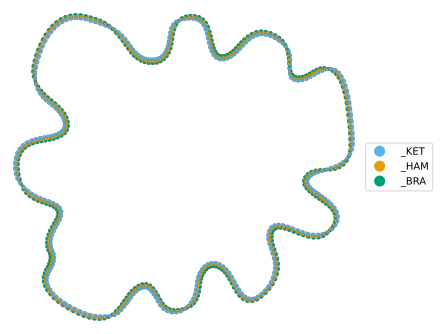

In [5]:
dmrg.TN_energy.draw(color=['_KET', '_HAM', '_BRA'])  # might be slow as uses force repulsion

Or if we want to plot with fixed positions:

In [6]:
from cmath import exp, pi
fix = {
    **{(f'I{i}', '_KET'): (100 * exp(2j*pi * i / 300).real, 100 * exp(2j*pi * i / 300).imag) for i in range(300)},
    **{(f'I{i}', '_HAM'): (105 * exp(2j*pi * i / 300).real, 105 * exp(2j*pi * i / 300).imag) for i in range(300)},
    **{(f'I{i}', '_BRA'): (110 * exp(2j*pi * i / 300).real, 110 * exp(2j*pi * i / 300).imag) for i in range(300)},
}

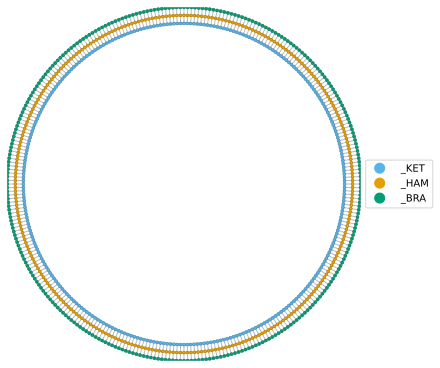

In [7]:
dmrg.TN_energy.draw(color=['_KET', '_HAM', '_BRA'], fix=fix, iterations=0)

The default algorithm settings are reasonable enough to get started with:

In [8]:
dmrg.solve(max_sweeps=4, verbosity=1, cutoffs=1e-6)

SWEEP-1, direction=R, max_bond=(8/8), cutoff:1e-06


100%|#########################################| 300/300 [00:07<00:00, 39.65it/s]

Energy: -132.17902072362483 ... not converged.
SWEEP-2, direction=R, max_bond=(8/16), cutoff:1e-06



100%|#########################################| 300/300 [00:04<00:00, 65.05it/s]

Energy: -132.87835865018573 ... not converged.
SWEEP-3, direction=R, max_bond=(16/32), cutoff:1e-06



100%|#########################################| 300/300 [00:09<00:00, 31.67it/s]

Energy: -132.9340131293506 ... not converged.
SWEEP-4, direction=R, max_bond=(32/64), cutoff:1e-06



100%|#########################################| 300/300 [01:16<00:00,  3.93it/s]

Energy: -132.94325522116424 ... not converged.


False

We are getting pretty close to the known energy already (closer than OBC at this length can get). The relative error is:

In [9]:
(dmrg.energy - E_exact) / abs(E_exact)

2.742481354549664e-05

Note that for PBC, the algorithm splits the chain into segments, and approximates the other segments with a SVD (the accuracies of the energies above are limited by this). Thus progress appears to pause at these points. The number of singular values kept for this environment approximation is recorded in ``dmrg.bond_sizes_ham`` and ``dmrg.bond_sizes_norm``:

In [10]:
dmrg.bond_sizes_norm

[[1, 1], [1, 2], [1, 5], [5, 11]]

In [11]:
dmrg.bond_sizes_ham

[[2, 2], [2, 4], [2, 6], [8, 16]]

To progress further might require tweaking the advanced options, for example, setting tighter tolerances for some of the settings found in:

In [12]:
dmrg.opts

{'default_sweep_sequence': 'R',
 'bond_compress_method': 'svd',
 'bond_compress_cutoff_mode': 'rel',
 'bond_expand_rand_strength': 1e-06,
 'local_eig_tol': 0.001,
 'local_eig_ncv': 4,
 'local_eig_backend': None,
 'local_eig_maxiter': None,
 'local_eig_EPSType': None,
 'local_eig_ham_dense': None,
 'local_eig_norm_dense': None,
 'periodic_segment_size': 0.5,
 'periodic_compress_method': 'isvd',
 'periodic_compress_norm_eps': 1e-06,
 'periodic_compress_ham_eps': 1e-06,
 'periodic_compress_max_bond': -1,
 'periodic_nullspace_fudge_factor': 1e-12,
 'periodic_canonize_inv_tol': 1e-10,
 'periodic_orthog_tol': 1e-06}

See ``quimb.tensor.tensor_dmrg.get_default_opts`` for detailed explanations of these quantities.
One could also supply custom sequences for the maximum allowed bond dimensions (e.g. ``dmrg.solve(..., bond_dims=[70, 80, 90])``) or bond compression cutoffs (e.g. ``dmrg.solve(..., cutoffs=[1e-9, 3e-10, 1e-10])``).

PBC DMRG error is, in particular, limited by the segment compression tolerances.

The full state can be retrieved from ``dmrg.state``:

In [13]:
gs = dmrg.state
gs.max_bond()

64

Z-Correlations
-------------

We could then calculate the ground-state z-correlations for example. ``MatrixProductState.correlation`` internally uses ``quimb.tensor.expect_TN_1D`` which can perform transfer matrix compression in order to efficiently compute expectations.

In [14]:
sz = spin_operator('Z').real
gs.correlation(sz, 0, 1)

-0.14627906251133044

However, if one was computing this for many sites, it would make sense to manually reuse parts of each contraction.
For example, if we are only interested in the first ``n`` sites, we can approximate the rest with an SVD:

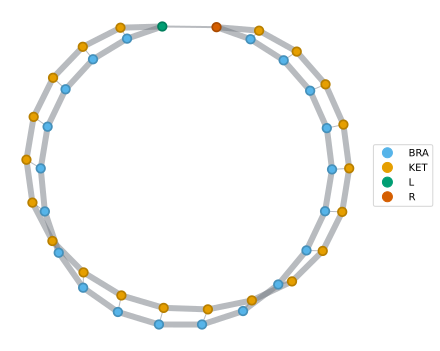

In [15]:
# Set up an overlap
p = dmrg.state
p.add_tag('KET')
q = p.H.retag({'KET': 'BRA'})
qp = q & p

# Replace all but 20 sites with an SVD
qp.replace_section_with_svd(20, 300, eps=1e-6, inplace=True, ltags='L', rtags='R')

qp.draw(color=['BRA', 'KET', 'L', 'R'])

Now we can define a correlation function on this much smaller network:

In [16]:
def sz_corr(i, j):
    itag = f"I{i}"
    jtag = f"I{j}"
    
    qp_i = qp.insert_operator(sz, ('KET', itag), ('BRA', itag))
    c_i = qp_i ^ all
    
    qp_j = qp.insert_operator(sz, ('KET', jtag), ('BRA', jtag))
    c_j = qp_j ^ all
    
    qp_ij = qp_i.insert_operator(sz, ('KET', jtag), ('BRA', jtag))
    c_ij = qp_ij ^ all
    
    return c_ij - c_i * c_j

We can then use this to compute the 20 correlations efficiently:

In [17]:
js = range(1, 20)
cs = [sz_corr(0, j) for j in js]

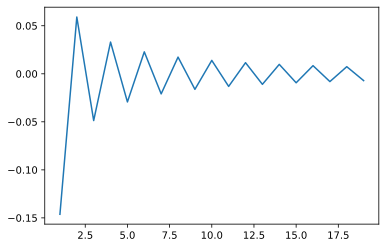

In [18]:
import matplotlib.pyplot as plt
plt.plot(js, cs)

Which looks as expected.

Compressed Density Matrix
------------------------

For operators on more than a few qubits we can compute a compressed density matrix. E.g. for 50 + 50 = 100 qubits:

In [19]:
sysa = range(0, 50)
sysb = range(50, 100)

rho_ab = gs.partial_trace_compress(sysa, sysb, max_bond=2**6, method='isvd')

In [20]:
rho_ab.ind_sizes()

{'_b506bbAAAXD': 64,
 '_b506bbAAASN': 64,
 '_b506bbAAATL': 64,
 '_b506bbAADro': 64,
 '_b506bbAADmy': 64,
 '_b506bbAADnw': 64,
 '_b506bbAADrr': 11,
 'kA': 64,
 'bA': 64,
 'kB': 64,
 'bB': 64}

Let's plot this:

In [21]:
# specify some coordinates to plot the remaining tensors
fix = {('_UP', '_SYSA'): (-1, +1), ('_DOWN', '_SYSA'): (-1, -1), 'kA': (-1, 1.5), 'bA': (-1, -1.5),
       ('_UP', '_SYSB'): (+1, +1), ('_DOWN', '_SYSB'): (+1, -1), 'kB': (+1, 1.5), 'bB': (+1, -1.5)}

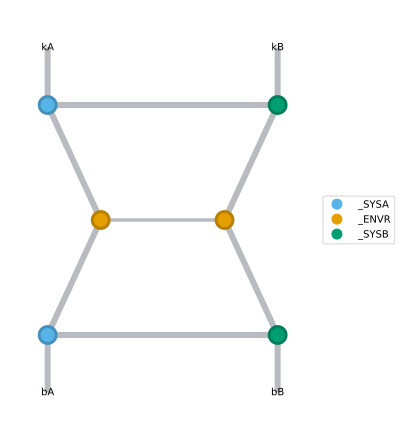

In [27]:
rho_ab.draw(color=['_SYSA', '_ENVR', '_SYSB'], show_tags=False, fix=fix)

You can see that because the state has PBC, there is a split 'environment' tensor carrying correlations the 'long-way-round'.

We can also check it's still normalized:

In [23]:
rho_ab.trace(['kA', 'kB'], ['bA', 'bB'])

0.9999999999999999

We could also estimate the genuine entanglement between the two subsytems. First we convert the compressed representation into a dense matrix, whilst also partially transposing one side:

In [24]:
# form single tensor
rho_ab_d = rho_ab ^ all

# turn tensor into a normal array whilst also partially transposing
rho_ab_pt_d = rho_ab_d.to_dense(['kA', 'bB'],
                                ['bA', 'kB'])
rho_ab_pt_d.shape

(4096, 4096)

Finally compute $\log_2 \left|\rho_{AB}^{T_B} \right|$:

In [25]:
E = log2(sum(abs(eigvalsh(rho_ab_pt_d))))

Which gives the logarithmic negativity between the two regions as (approximately because of the limited bond in the compression):

In [26]:
E

2.091112790808372